<a id='top'></a>
# Cell segmentation
for my notebook not in colab

## Table of contents

- [Architecture](#Architecture)
- [Custom loop](#Custom_loop)
- [Showing results](#Showing_results)
    - [on dataset](#sr_on_dataset)
    - [on our data](#sr_on_our_data)
        - [necessary functions](#necessary_functions)
        - [figures](#figures)

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import ndimage
import os
from scipy import ndimage
import mahotas as mh
import tensorflow as tf
from tensorflow import keras
import zipfile
from datetime import datetime, timedelta
import tifffile
from numba import jit
from skimage import filters
#%matplotlib inline
%matplotlib notebook


In [50]:
# Variables
MODEL_WEIGHTS = '2020-12-27-MultiCellNet-model_weights.h5'
PATH_TO_FIGURE='data/image_testee.tiff'

<a id='Architecture'></a>
## Architecture
[top](#top)

**Architecture from:** R. Sarkar, S. Mukherjee, E. Labruyère and J.-C. Olivo-Marin, "Learning to segment clustered amoeboid cells from brightfield microscopy via multi-task learning withadaptive weight selection", *arXiv:2005.09372v1*, 2020 (__[url](https://arxiv.org/pdf/2005.09372v1.pdf)__)

In [51]:
keras.backend.clear_session()
np.random.seed(19)
tf.random.set_seed(19)

In [52]:
def create_model():

  input_ = keras.layers.Input(shape=(256,256,1))
  BN0 = keras.layers.BatchNormalization()(input_)

  # Region sub-network

  RC1 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(BN0)
  RBN1 = keras.layers.BatchNormalization()(RC1)
  RA1 = keras.layers.Activation('relu')(RBN1)
  RP1 = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(RA1)

  RC2 = keras.layers.Conv2D(32, 3, padding='same', kernel_initializer = 'he_normal')(RP1)
  RBN2 = keras.layers.BatchNormalization()(RC2)
  RA2 = keras.layers.Activation('relu')(RBN2)
  RP2 = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(RA2)

  RC3 = keras.layers.Conv2D(64, 3, padding='same', kernel_initializer = 'he_normal')(RP2)
  RBN3 = keras.layers.BatchNormalization()(RC3)
  RA3 = keras.layers.Activation('relu')(RBN3)
  RP3 = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(RA3)

  RC4 = keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = 'he_normal')(RP3)
  RBN4 = keras.layers.BatchNormalization()(RC4)
  RA4 = keras.layers.Activation('relu')(RBN4)

  RC5 = keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = 'he_normal')(RA4)
  RBN5 = keras.layers.BatchNormalization()(RC5)
  RC6 = keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = 'he_normal')(RBN4)
  RBN6 = keras.layers.BatchNormalization()(RC6)
  RConc1 = tf.concat((RBN5, RBN6), axis=3)
  RUp1 = keras.layers.UpSampling2D(size=2)(RConc1)
  RA5 = keras.layers.Activation('relu')(RUp1)

  RC7 = keras.layers.Conv2D(64, 3, padding='same', kernel_initializer = 'he_normal')(RA5)
  RBN7 = keras.layers.BatchNormalization()(RC7)
  RC8 = keras.layers.Conv2D(64, 3, padding='same', kernel_initializer = 'he_normal')(RBN3)
  RBN8 = keras.layers.BatchNormalization()(RC7)
  RConc2 = tf.concat((RBN7, RBN8), axis=3)
  RUp2 = keras.layers.UpSampling2D(size=2)(RConc2)
  RA6 = keras.layers.Activation('relu')(RUp2)

  RC9 = keras.layers.Conv2D(32, 3, padding='same', kernel_initializer = 'he_normal')(RA6)
  RBN9 = keras.layers.BatchNormalization()(RC9)
  RC10 = keras.layers.Conv2D(32, 3, padding='same', kernel_initializer = 'he_normal')(RBN2)
  RBN10 = keras.layers.BatchNormalization()(RC10)
  RConc3 = tf.concat((RBN9, RBN10), axis=3)
  RUp3 = keras.layers.UpSampling2D(size=2)(RConc3)
  RA7 = keras.layers.Activation('relu')(RUp3)

  RC11 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(RA7)
  RBN11 = keras.layers.BatchNormalization()(RC11)
  RC12 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(RBN1)
  RBN12 = keras.layers.BatchNormalization()(RC12)
  RConc4 = tf.concat((RBN11, RBN12), axis=3)
  RA8 = keras.layers.Activation('relu')(RConc4)

  RC13 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(RA8)
  RBN13 = keras.layers.BatchNormalization()(RC13)
  RA9 = keras.layers.Activation('relu')(RBN13)

  RC14 = keras.layers.Conv2D(1, 3, padding='same', kernel_initializer = 'he_normal')(RA9)
  Routput_ = keras.layers.Activation('sigmoid')(RC14)


  # Edge sub-network

  EI1 = RA1
  EI2 = keras.layers.UpSampling2D(size=2)(RA2)
  EI3 = RA9
  EConc0 = tf.concat((EI1, EI2, EI3), axis=3)
  EBN0 = keras.layers.BatchNormalization()(EConc0)
  EA0 = keras.layers.Activation('relu')(EBN0)

  EC1 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(EA0)
  EBN1 = keras.layers.BatchNormalization()(EC1)
  EA1 = keras.layers.Activation('relu')(EBN1)
  EP1 = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(EA1)

  EC2 = keras.layers.Conv2D(32, 3, padding='same', kernel_initializer = 'he_normal')(EP1)
  EBN2 = keras.layers.BatchNormalization()(EC2)
  EA2 = keras.layers.Activation('relu')(EBN2)
  EP2 = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(EA2)

  EC3 = keras.layers.Conv2D(64, 3, padding='same', kernel_initializer = 'he_normal')(EP2)
  EBN3 = keras.layers.BatchNormalization()(EC3)
  EA3 = keras.layers.Activation('relu')(EBN3)
  EP3 = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(EA3)

  EC4 = keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = 'he_normal')(EP3)
  EBN4 = keras.layers.BatchNormalization()(EC4)
  EA4 = keras.layers.Activation('relu')(EBN4)

  EC5 = keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = 'he_normal')(EA4)
  EBN5 = keras.layers.BatchNormalization()(EC5)
  EC6 = keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = 'he_normal')(EBN4)
  EBN6 = keras.layers.BatchNormalization()(EC6)
  EConc1 = tf.concat((EBN5, EBN6), axis=3)
  EUp1 = keras.layers.UpSampling2D(size=2)(EConc1)
  EA5 = keras.layers.Activation('relu')(EUp1)

  EC7 = keras.layers.Conv2D(64, 3, padding='same', kernel_initializer = 'he_normal')(EA5)
  EBN7 = keras.layers.BatchNormalization()(EC7)
  EC8 = keras.layers.Conv2D(64, 3, padding='same', kernel_initializer = 'he_normal')(EBN3)
  EBN8 = keras.layers.BatchNormalization()(EC7)
  EConc2 = tf.concat((EBN7, EBN8), axis=3)
  EUp2 = keras.layers.UpSampling2D(size=2)(EConc2)
  EA6 = keras.layers.Activation('relu')(EUp2)

  EC9 = keras.layers.Conv2D(32, 3, padding='same', kernel_initializer = 'he_normal')(EA6)
  EBN9 = keras.layers.BatchNormalization()(EC9)
  EC10 = keras.layers.Conv2D(32, 3, padding='same', kernel_initializer = 'he_normal')(EBN2)
  EBN10 = keras.layers.BatchNormalization()(EC10)
  EConc3 = tf.concat((EBN9, EBN10), axis=3)
  EUp3 = keras.layers.UpSampling2D(size=2)(EConc3)
  EA7 = keras.layers.Activation('relu')(EUp3)

  EC11 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(EA7)
  EBN11 = keras.layers.BatchNormalization()(EC11)
  EC12 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(EBN1)
  EBN12 = keras.layers.BatchNormalization()(EC12)
  EConc4 = tf.concat((EBN11, EBN12), axis=3)
  EA8 = keras.layers.Activation('relu')(EConc4)

  EC13 = keras.layers.Conv2D(16, 3, padding='same', kernel_initializer = 'he_normal')(EA8)
  EBN13 = keras.layers.BatchNormalization()(EC13)
  EA9 = keras.layers.Activation('relu')(EBN13)

  EC14 = keras.layers.Conv2D(1, 3, padding='same', kernel_initializer = 'he_normal')(EA9)
  Eoutput_ = keras.layers.Activation('sigmoid')(EC14)


  # defining the model

  return keras.Model(inputs=[input_], outputs=[Routput_, Eoutput_])

<a id='Custom_loop'></a>
## Custom loop
[top](#top)

In [53]:
def transform_to_tensor(s_example):
  
  feature_description = {
    'x': tf.io.FixedLenFeature([], tf.string),
    'y_region': tf.io.FixedLenFeature([], tf.string),
    'y_edge': tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(s_example, feature_description)

  X = tf.io.parse_tensor(example['x'], tf.float32)
  y_region = tf.io.parse_tensor(example['y_region'], tf.float32)
  y_edge = tf.io.parse_tensor(example['y_edge'], tf.float32)

  return X, y_region, y_edge

In [54]:
def get_dataset(batch_size=32, n_readers=32, shuffle_buffer_size=100, training=True):
  test_val_size = 53
  if training:
    initial_dataset = tf.data.Dataset.list_files([os.path.join('data', 'train_augmented', f) for f in os.listdir(os.path.join(ROOT, 'train_augmented'))])
    interleave_dataset = initial_dataset.interleave(lambda file: tf.data.TFRecordDataset([file], compression_type="GZIP"), cycle_length=n_readers, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    transformed_dataset = interleave_dataset.map(transform_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    shuffled_dataset = transformed_dataset.shuffle(shuffle_buffer_size)
    return shuffled_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    #return initial_dataset
  else:
    initial_dataset = tf.data.TFRecordDataset([os.path.join('data', 'val.tfrecord')], compression_type="GZIP")
    transformed_dataset = initial_dataset.map(transform_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return transformed_dataset.batch(test_val_size)

In [55]:
def loss_function_subnetwork(y_true, y_pred):
  return tf.constant(1, dtype=tf.float32) - 2*tf.reduce_sum(tf.multiply(y_true, y_pred), [1,2])/(tf.reduce_sum(y_true, [1,2]) + tf.reduce_sum(y_pred, [1,2]) + tf.constant(10**-10 , dtype=tf.float32))

<a id='Showing_results'></a>
## Showing results
 - [on data set](#sr_on_dataset)
 - [on our data](#sr_on_our_data)
 
 
[top](#top)

<a id='sr_on_dataset'></a>
### on dataset

In [9]:
for data in get_dataset(training=False):
  X_val, y_region_val, y_edge_val = data

model = create_model()
model.load_weights(os.path.join('data', MODEL_WEIGHTS))

y_predr, y_prede = model(X_val, training=False)

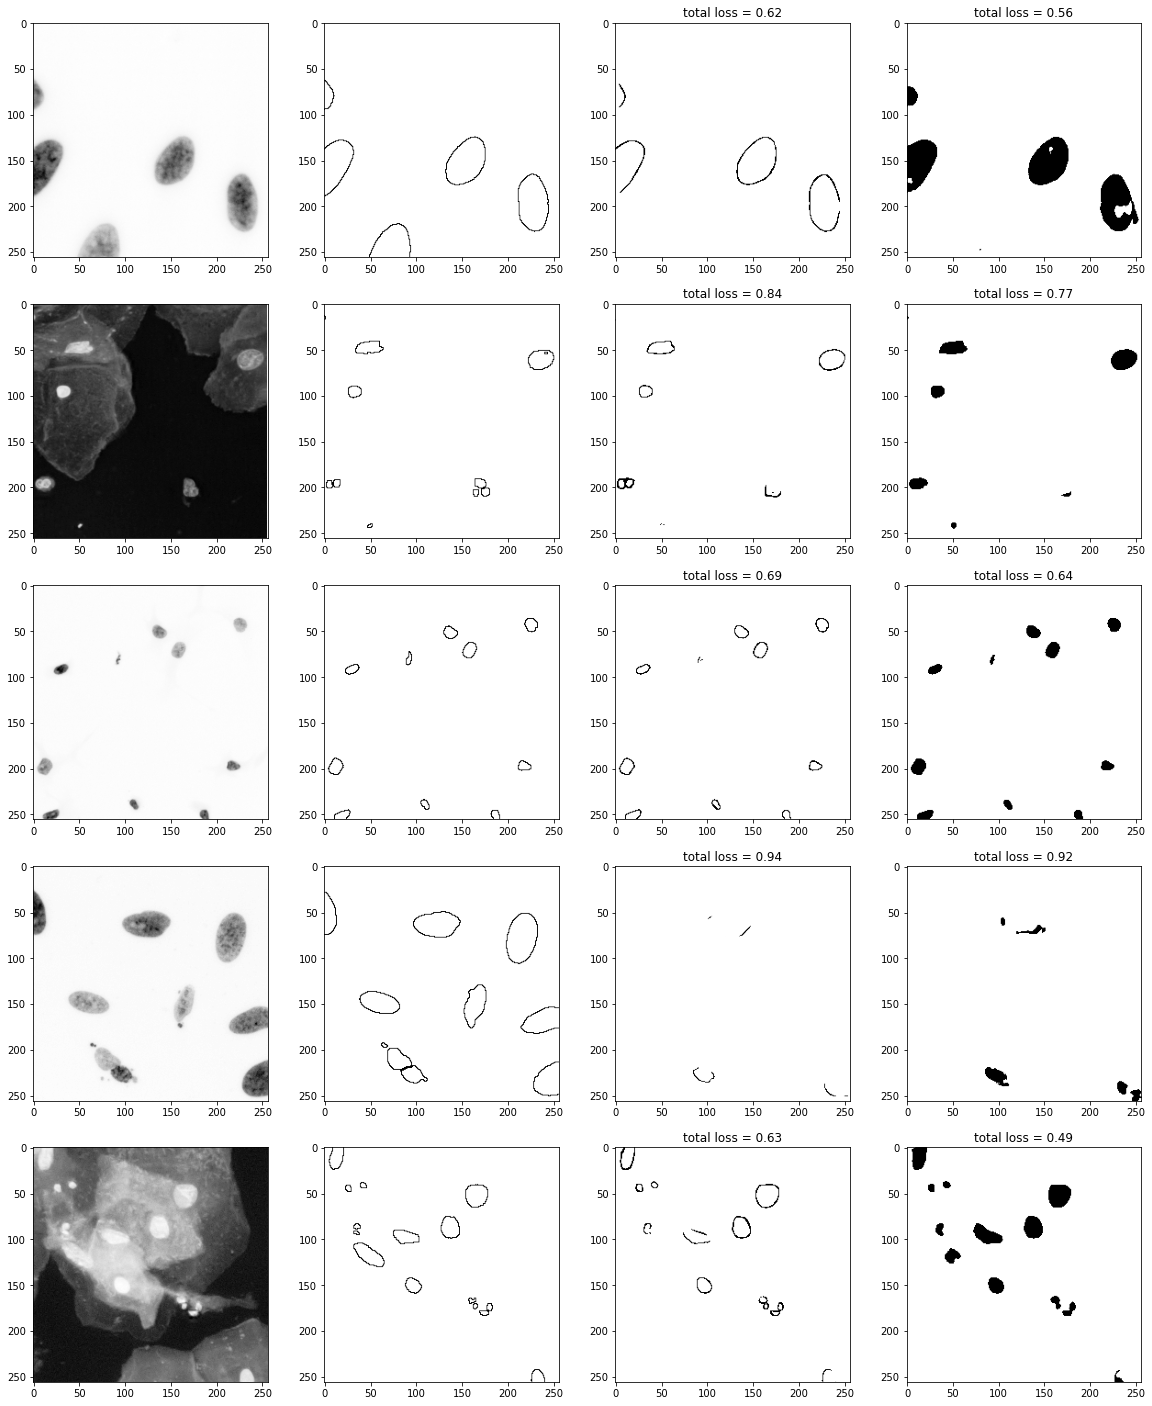

In [18]:
N=5
fig, axs = plt.subplots(N,4, figsize=(20,N*5))
axs=axs.flatten()
for n in range(N):
  axs[4*n].imshow(X_val[n][:,:,0], 'Greys')
  axs[4*n+1].imshow(y_edge_val[n][:,:,0], 'Greys')
  axs[4*n+2].imshow(y_prede[n][:,:,0], 'Greys')
  axs[4*n+3].imshow(y_predr[n][:,:,0], 'Greys')
  axs[4*n+2].set_title('total loss = {}'.format(round(float(tf.reduce_mean(loss_function_subnetwork(y_edge_val[n], y_prede[n]))), 2)))
  axs[4*n+3].set_title('total loss = {}'.format(round(float(tf.reduce_mean(loss_function_subnetwork(y_region_val[n], y_predr[n]))), 2)))


<a id='sr_on_our_data'></a>
### on our data
- [necessary functions](#necessary_functions)
- [figures](#figures)

[top](#top)

<a id='necessary_functions'></a>
#### necessary functions
[top](#top)

In [56]:
def duration(function, *args, **kwargs):
    def modified_function(*args, **kwargs):
        t0=datetime.today()
        ret=function(*args, **kwargs)
        t1=datetime.today()
        print('duration of {}: {}'.format(function, (t1-t0)))
        return ret
    return modified_function

In [57]:
model = create_model()
model.load_weights(os.path.join('data', MODEL_WEIGHTS))

DAPI = tifffile.imread(PATH_TO_FIGURE, key=0)
TUMOR = tifffile.imread(PATH_TO_FIGURE, key=2)

In [58]:
@duration
def segment_nuclei(Image, model):
    h, w = Image.shape
    ImageG = ndimage.gaussian_filter(Image, 1)
    
    n_row, n_col = h//256 + (h%256 != 0), w//256 + (w%256 != 0)
    M_Image = np.zeros((n_row*256, n_col*256))
    M_Image[:h, :w] = ImageG
    
    
    
    M_r, M_e = np.zeros((n_row*256, n_col*256)), np.zeros((n_row*256, n_col*256))
    
    A = np.stack([M_Image[256*r:256*(r+1), 256*c:256*(c+1)].reshape(256,256,1) for r in range(n_row) for c in range(n_col)], axis=0)
    y_r, y_e = model(A, training=False)
    
    n = 0
    for r in range(n_row):
        for c in range(n_col):
            M_r[256*r:256*(r+1), 256*c:256*(c+1)] = y_r[n][:,:,0]
            M_e[256*r:256*(r+1), 256*c:256*(c+1)] = y_e[n][:,:,0]
            n += 1
            
    segmented_nuclei = 1*ndimage.binary_opening(np.where(M_r-M_e < 1, 0, M_r-M_e), np.ones((3,3)))

    
    return segmented_nuclei[:h, :w]

In [59]:
@duration
def label_segmented_nuclei(segmented_nuclei):
    label, n = ndimage.label(segmented_nuclei)
    return label, n

In [60]:
@jit(nopython=True)
def filter_(buffer):
    if buffer.sum() == 0:
        return 0
    else:
        s = set(buffer)
        if 0 in s:
            s.remove(0)
        if len(s) > 1:
            return 0
        else:
            return next(iter(s))

In [61]:
@duration
def label_cells_ndimage(labelled_nuclei, size_cytoplasm=15):
    labelled_cells = labelled_nuclei.copy()
    d_init = datetime.today()
    for i in range(size_cytoplasm):
        d0 = datetime.today()
        print('\r{}/{} -- elapsed time: {}s'.format(i+1, size_cytoplasm, (d0-d_init).total_seconds()), end='')
        labelled_cells = ndimage.generic_filter(labelled_cells, filter_, footprint=np.array([[0,1,0], [1,1,1], [0,1,0]]))
    return labelled_cells

In [62]:
@jit(nopython=True)
def create_buffer(i, j, M):
    B = np.array([M[i-1,j], M[i,j-1], M[i,j], M[i,j+1], M[i+1,j]])
    return B


@jit(nopython=True, parallel=True)
def step_filter(M):
    r, c = M.shape
    M0 = np.zeros((r+2, c+2))
    M0[1:-1, 1:-1] = M
    
    fM = np.zeros(M0.shape, dtype='int32')
    
    for i in range(1, r+1):
        for j in range(1, c+1):
            fM[i,j] = int(filter_(create_buffer(i, j, M0)))
    
    return fM[1:-1,1:-1]


@duration
@jit(nopython=True)
def label_cells_numba(labelled_nuclei, size_cytoplasm=15):
    labelled_cells = labelled_nuclei.copy()
    for i in range(size_cytoplasm):
        labelled_cells = step_filter(labelled_cells)
    return labelled_cells

In [63]:
@duration
def find_labelled_cells(labelled_cells):
    slices = ndimage.find_objects(labelled_cells)
    return [(None, None)] + slices

In [64]:
@duration
def fill_nuclei_holes(labelled_nuclei, n_cells, slices):
    filled_holes_nuclei = np.zeros(labelled_nuclei.shape)
    for cell in range(1, n_cells+1):
        filled_holes_nuclei[slices[cell]] += cell * ndimage.binary_fill_holes(np.where(labelled_nuclei[slices[cell]] == cell, 1, 0))
    return filled_holes_nuclei

In [65]:
@duration
def get_cells_value(Layer, labelled_cells, n_cells, slices, method='sum'):
    # the different methods could be: 'sum', 'mean', 'median', 'max', 'min'
    values = []
    
    if method == 'mean':
        for cell in range(1, n_cells+1):
            value = Layer[slices[cell]][labelled_cells[slices[cell]] == cell].mean()
            values.append(value)
        
    elif method == 'sum':
        for cell in range(1, n_cells+1):
            value = Layer[slices[cell]][labelled_cells[slices[cell]] == cell].sum()
            values.append(value)
    
    elif method == 'median':
        for cell in range(1, n_cells+1):
            value = np.median(Layer[slices[cell]][labelled_cells[slices[cell]] == cell])
            values.append(value)
            
    elif method == 'max':
        for cell in range(1, n_cells+1):
            value = Layer[slices[cell]][labelled_cells[slices[cell]] == cell].max()
            values.append(value)
            
    elif method == 'min':
        for cell in range(1, n_cells+1):
            value = Layer[slices[cell]][labelled_cells[slices[cell]] == cell].min()
            values.append(value)
        
    else:
        raise ValueError('unknown method')

    
    return values    

In [66]:
@duration
def plot_relabelled_cells(labelled_cells, n_cells, slices, cells_to_show):      
    relabelled_cells = np.zeros(labelled_cells.shape)
    
    for cell in range(1, n_cells+1):
        if cells_to_show[cell-1]:
            relabelled_cells[slices[cell]][(labelled_cells)[slices[cell]] == cell] = 2
        else:
            relabelled_cells[slices[cell]][(labelled_cells)[slices[cell]] == cell] = 1
            
    return relabelled_cells    

In [67]:
@duration
def get_cells_boundaries(labelled_cells, n_cells, slices):
    cells_boundaries = np.zeros(labelled_cells.shape)
    for cell in range(1, n_cells+1):
        cells_boundaries[slices[cell]] += np.where(labelled_cells[slices[cell]] == cell, 1, 0) - ndimage.binary_erosion(np.where(labelled_cells[slices[cell]] == cell, 1, 0))
    return cells_boundaries    

In [75]:
# I will only use the pipeline created with numba and not ndimage: it is much faster
@duration
def segment_cells_pipeline_numba(Image, model, size_cytoplasm=15):
    ## (1) Determine the segmented_nuclei from the Image thanks to the model
    segmented_nuclei = segment_nuclei(Image, model)
    
    ## (1bis) Fill the holes in the nuclei
    segmented_nuclei = ndimage.binary_fill_holes(segmented_nuclei)

    ## (2) Determine the labelled_nuclei and the number of cells from the segmented_nuclei
    labelled_nuclei, n_cells = label_segmented_nuclei(segmented_nuclei)
    
    ## slices theese objects or not to determine the max DAPI for each nuclei. if the max is less than
    # the threshold, the nuclei is not taking into account. Default threshold is Otsu threshold.
    
    ## (3) Determine the labelled_cells from the labelled_nuclei, given a size of the cytoplasm
    labelled_cells = label_cells_numba(labelled_nuclei, size_cytoplasm=size_cytoplasm)
    
    ## (4) Get the slices of the labelled_cells
    slices = find_labelled_cells(labelled_cells)
    
    ## (5) Get the cells boundaries
    cells_boundaries = get_cells_boundaries(labelled_cells, n_cells, slices)
   
    
    return segmented_nuclei, labelled_nuclei, labelled_cells, n_cells, slices, cells_boundaries

In [69]:
@duration
def plot_segmented_nuclei_on_layer(Layer, segmented_nuclei, dbox=((0, 0), (np.inf, np.inf))):
    if Layer.shape != segmented_nuclei.shape:
        raise RunTimeError('the two layers do not have the same shape')
    
    h, w = Layer.shape
    ((x_min, y_min), (x_max, y_max)) = dbox
    x_min, y_min, x_max, y_max = int(max(0, x_min)), int(max(0, y_min)), int(min(w, x_max)), int(min(h, y_max))
    
    ## normalization of Layer
    Layer_max = Layer[y_min:y_max, x_min:x_max].max()
    
    ## Building a blue layer for the segmented_nuclei
    Zeros = np.zeros(Layer[y_min:y_max, x_min:x_max].shape)
    Alpha = np.ones(Layer[y_min:y_max, x_min:x_max].shape) * 0.2
    Alpha[segmented_nuclei[y_min:y_max, x_min:x_max] == 0] = 0
    
    RGBA_segmented_nuclei = np.stack([Zeros, Zeros, segmented_nuclei[y_min:y_max, x_min:x_max], Alpha], axis=-1)
    
    ## Plot the two
    fig, ax = plt.subplots(1,1)
    ax.imshow(Layer[y_min:y_max, x_min:x_max]/Layer_max, 'Greys')
    ax.imshow(RGBA_segmented_nuclei)    

In [70]:
@duration
def segment_labelled_cells(labelled_cells):
    segmented_cells = np.zeros(labelled_cells.shape)
    segmented_cells[labelled_cells>0] = 1
    return segmented_cells

In [71]:
@duration
def plot_segmented_cells_on_layer(Layer, segmented_cells, dbox=((0, 0), (np.inf, np.inf))):
    if Layer.shape != segmented_cells.shape:
        raise ValueError('the two layers do not have the same shape')
    
    h, w = Layer.shape
    ((x_min, y_min), (x_max, y_max)) = dbox
    x_min, y_min, x_max, y_max = int(max(0, x_min)), int(max(0, y_min)), int(min(w, x_max)), int(min(h, y_max))
    
    ## normalization of Layer
    Layer_max = Layer[y_min:y_max, x_min:x_max].max()
    
    ## Building a blue layer for the segmented_nuclei
    Zeros = np.zeros(Layer[y_min:y_max, x_min:x_max].shape)
    Alpha = np.ones(Layer[y_min:y_max, x_min:x_max].shape) * 0.2
    Alpha[segmented_cells[y_min:y_max, x_min:x_max] == 0] = 0
    
    RGBA_segmented_cells = np.stack([0.5*segmented_cells[y_min:y_max, x_min:x_max], Zeros, segmented_cells[y_min:y_max, x_min:x_max], Alpha], axis=-1)
    
    ## Plot the two
    fig, ax = plt.subplots(1,1)
    ax.imshow(Layer[y_min:y_max, x_min:x_max]/Layer_max, 'Greys')
    ax.imshow(RGBA_segmented_cells)    

In [72]:
@duration
def plot_segmented_cells_and_nuclei_on_layer(Layer, segmented_cells, segmented_nuclei, cells_boundaries, dbox=((0, 0), (np.inf, np.inf))):
    if Layer.shape != segmented_cells.shape or Layer.shape != segmented_nuclei.shape or Layer.shape != cells_boundaries.shape :
        raise ValueError('the inputs do not have the same shape')
    
    h, w = Layer.shape
    ((x_min, y_min), (x_max, y_max)) = dbox
    x_min, y_min, x_max, y_max = int(max(0, x_min)), int(max(0, y_min)), int(min(w, x_max)), int(min(h, y_max))
    
    ## normalization of Layer
    Layer_max = Layer[y_min:y_max, x_min:x_max].max()
    
    ## get the segmented_nuclei colored in blue
    Zeros = np.zeros(Layer[y_min:y_max, x_min:x_max].shape)
    Alpha = np.ones(Layer[y_min:y_max, x_min:x_max].shape) * 0.2
    Alpha[segmented_nuclei[y_min:y_max, x_min:x_max] == 0] = 0
    
    RGBA_segmented_nuclei = np.stack([Zeros, Zeros, segmented_nuclei[y_min:y_max, x_min:x_max], Alpha], axis=-1)
    
    ## get the segmented_cells without nuclei colored in purple
    Alpha = np.ones(Layer[y_min:y_max, x_min:x_max].shape) * 0.1
    Alpha[(segmented_cells[y_min:y_max, x_min:x_max] == 0)|(segmented_nuclei[y_min:y_max, x_min:x_max] > 0)|(cells_boundaries[y_min:y_max, x_min:x_max] > 0)] = 0
    
    RGBA_segmented_cells = np.stack([1*segmented_cells[y_min:y_max, x_min:x_max], Zeros, segmented_cells[y_min:y_max, x_min:x_max], Alpha], axis=-1)
    
    ## get the cells boundaries colored in red
    Alpha = np.ones(Layer[y_min:y_max, x_min:x_max].shape) * 0.2
    Alpha[cells_boundaries[y_min:y_max, x_min:x_max] == 0] = 0
    RGBA_cells_boundaries = np.stack([cells_boundaries[y_min:y_max, x_min:x_max], Zeros, Zeros, Alpha], axis=-1)
    
    
    ## plot the four
    fig, ax = plt.subplots(1,1)
    ax.imshow(Layer[y_min:y_max, x_min:x_max]/Layer_max, 'Greys')
    ax.imshow(RGBA_segmented_nuclei)
    ax.imshow(RGBA_segmented_cells)
    ax.imshow(RGBA_cells_boundaries)

In [73]:
@duration
def plot_cells_boundaries_on_layer(Layer, cells_boundaries, dbox=((0, 0), (np.inf, np.inf))):
    if Layer.shape != cells_boundaries.shape :
        raise ValueError('the inputs do not have the same shape')
    
    h, w = Layer.shape
    ((x_min, y_min), (x_max, y_max)) = dbox
    x_min, y_min, x_max, y_max = int(max(0, x_min)), int(max(0, y_min)), int(min(w, x_max)), int(min(h, y_max))
    
    ## normalization of Layer
    Layer_max = Layer[y_min:y_max, x_min:x_max].max()
    
    ## get the cells_boundaries colored in red
    Zeros = np.zeros(Layer[y_min:y_max, x_min:x_max].shape)
    Alpha = np.ones(Layer[y_min:y_max, x_min:x_max].shape) * 0.2
    Alpha[cells_boundaries[y_min:y_max, x_min:x_max] == 0] = 0
    
    RGBA_cells_boundaries = np.stack([cells_boundaries[y_min:y_max, x_min:x_max], Zeros, Zeros, Alpha], axis=-1)
    
    
    ## plot the two
    fig, ax = plt.subplots(1,1)
    ax.imshow(Layer[y_min:y_max, x_min:x_max]/Layer_max, 'Greys')
    ax.imshow(RGBA_cells_boundaries)

<a id='figures'></a>
#### figures
[top](#top)

- The whole slide (the DAPI)

<IPython.core.display.Javascript object>


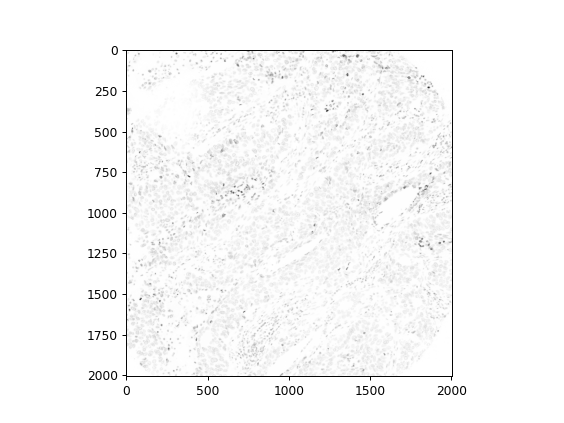

In [74]:
fig, ax = plt.subplots(1,1)
ax.imshow(DAPI, 'Greys')

- Segmented cells

In [30]:
segmented_nuclei, labelled_nuclei, labelled_cells, n_cells, slices, cells_boundaries = segment_cells_pipeline_numba(DAPI, model, size_cytoplasm=15)

duration of <function segment_nuclei at 0x7ff77b9724c0>: 0:00:11.765070s
duration of <function label_segmented_nuclei at 0x7ff4294dd430>: 0:00:00.028790s
duration of CPUDispatcher(<function label_cells_numba at 0x7ff4294dd9d0>): 0:00:25.506996s
duration of <function find_labelled_cells at 0x7ff7d453d8b0>: 0:00:00.031724s
duration of <function get_cells_boundaries at 0x7ff4294e9430>: 0:00:00.559912s
duration of <function segment_cells_pipeline_numba at 0x7ff4294e95e0>: 0:00:38.049884s


In [31]:
segmented_cells = segment_labelled_cells(labelled_cells)

duration of <function segment_labelled_cells at 0x7ff4294e9940>: 0:00:00.024273s


In [37]:
plot_segmented_cells_and_nuclei_on_layer(DAPI, segmented_cells, segmented_nuclei, cells_boundaries)

<IPython.core.display.Javascript object>

duration of <function plot_segmented_cells_and_nuclei_on_layer at 0x7ff429002dc0>: 0:00:01.106323s


In [36]:
print('Number of cells on the slide: {}'.format(n_cells))

Number of cells on the slide: 7107


- Labelled nuclei

<IPython.core.display.Javascript object>


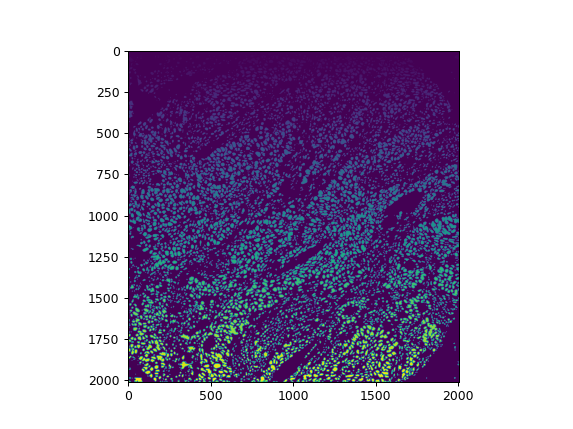

In [34]:
fig, ax = plt.subplots(1,1)
ax.imshow(labelled_nuclei)

- Get the marker value of each cells based on the segmentation and the other layers

duration of <function get_cells_value at 0x7ff7d453d940>: 0:00:00.122550s


<IPython.core.display.Javascript object>


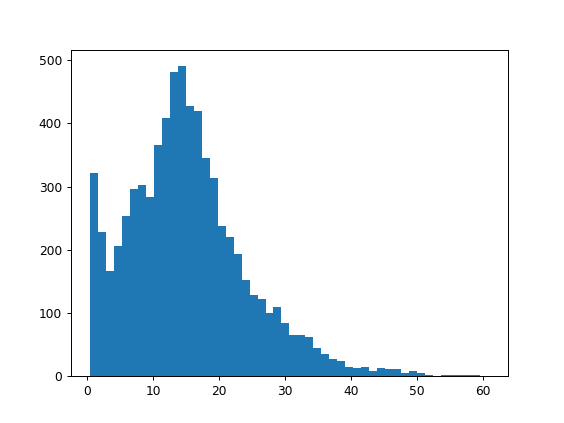

In [39]:
## (1) Determine for each cells the value of the marker for the layer TUMOR, with 'mean' method
values = get_cells_value(DAPI, labelled_cells, n_cells, slices, method='max')

## (2) Plot the corresponding histogram
fig, ax = plt.subplots(1,1)
_ = ax.hist(values, bins=50)

In [42]:
filters.threshold_otsu(image=DAPI) # value of the background

6.5279193

<IPython.core.display.Javascript object>


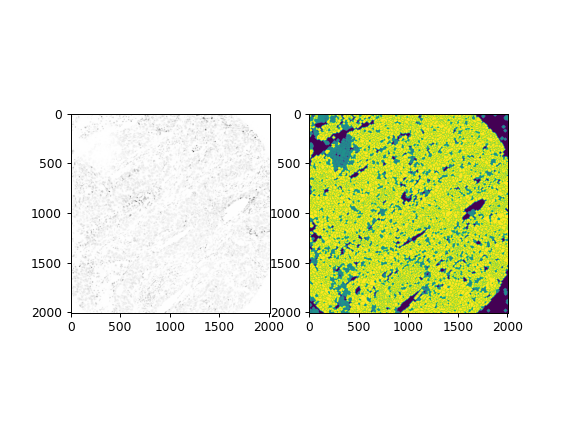

duration of <function plot_relabelled_cells at 0x7ff77b972310>: 0:00:00.065513s


In [41]:
## (3) Plot the value > background (determined thanks to the otsu method)
fig, axs = plt.subplots(1,2)
axs = axs.flatten()
axs[0].imshow(DAPI, 'Greys')
axs[1].imshow(plot_relabelled_cells(labelled_cells, n_cells, slices, np.array(values)> 6.5279193))

<IPython.core.display.Javascript object>


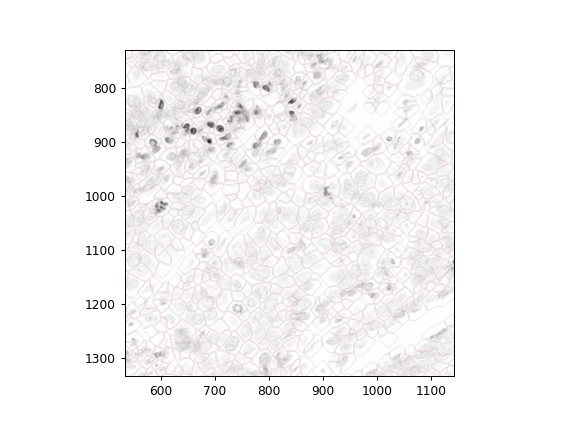

duration of <function plot_cells_boundaries_on_layer at 0x7ff426a26d30>: 0:00:00.769521s


In [43]:
plot_cells_boundaries_on_layer(DAPI, cells_boundaries)